In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_roc(i, fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
import mnist
import tensorflow as tf
import contingency_data
import numpy as np
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# number of classes trained on
num_classes = 2
num_adversarial = 10 #how many adversarial examples should be generated (if any) per iteration
num_adversarial_train = 5 # how many iterations for the adversarial

/Users/LeanderK/Documents/ML/contingency/venv/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.429688
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.999742
Final Accuracy on unexpected data: 0.720101
Final Accuracy on random data: 0.83352


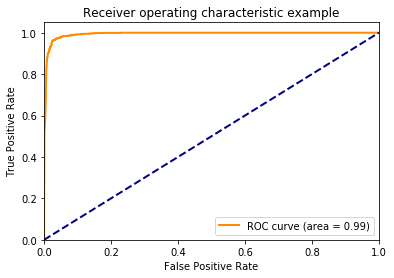

In [3]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withoutContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

Training Accuracy in iteration  0 : 0.429688
Training Accuracy in iteration  50 : 1.0
Training Accuracy in iteration  100 : 1.0
Training Accuracy in iteration  150 : 1.0
Final Accuracy on only valid classes: 0.999226
Final Accuracy on unexpected data: 0.481294
Final Accuracy on random data: 1.0


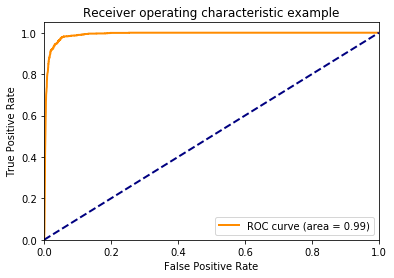

In [16]:
tf.reset_default_graph()
cont_data = mnist.MNISTContData(num_classes)
mnistCont = mnist.MNistContingency(learning_rate, num_adversarial, num_adversarial_train, cont_data)
(fpr, tpr, roc_auc, pred, model) = mnist.run(mnistCont.withRandomContingency, learning_rate, num_adversarial, cont_data, batch_size, num_steps)
plot_roc(0, fpr, tpr, roc_auc)

In [23]:
(test_img, test_lbls) = cont_data.next_test_batch(10)
(unexp_img, unexp_lbls) = cont_data.unexpected_data()
unexp_img = unexp_img[:10]
unexp_lbls = unexp_lbls[:10]
with tf.Session() as session:
    (acc_test, pred_test) = session.run(
                    [model['acc_op'], model['pred_op']], 
                    feed_dict={'images': test_img, 'labels': test_lbls, 'is_training': False}
                )
    (acc_unexp, pred_unexp) = session.run(
                    [model['acc_op'], model['pred_op']], 
                    feed_dict={'images': unexp_img, 'labels': unexp_lbls, 'is_training': False}
                )

TypeError: Cannot interpret feed_dict key as Tensor: The name 'images' refers to an Operation, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [22]:
(1-pred[:10,0])

array([  1.48781538e-02,   8.13535213e-01,   2.34544277e-04,
         8.80623698e-01,   7.41061449e-01,   3.75491381e-03,
         1.59448385e-03,   8.23795795e-04,   9.51826572e-04,
         6.31923079e-02], dtype=float32)

In [13]:
from scipy import stats
stats.describe(pred[:,0])

DescribeResult(nobs=4230, minmax=(9.2266767e-08, 1.0), mean=0.5564909, variance=0.2149256, skewness=-0.23432300984859467, kurtosis=-1.8501471260270785)

0.0


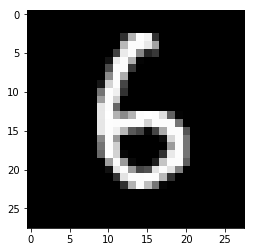

In [8]:
import matplotlib.pyplot as plt
print(cont_data.unexpected_data()[1][10])
plt.gray()
plt.imshow(cont_data.unexpected_data()[0][10].reshape([28, 28]))